In [175]:
import os
import zipfile

path = os.path.join(os.getcwd(), 'data', 'docx35.zip')
archive = zipfile.ZipFile(path, 'r')

# 1. Getting data

In [176]:
import re
import docx
import pandas as pd

def get_docs_data():
    for name in archive.namelist():
        if re.fullmatch(r'.*\.docx', name) == None:
            continue 
        with archive.open(name) as file:
            doc = docx.Document(file)
            contents = {'paragraphs': [p.text for p in doc.paragraphs if len(p.text) > 0]}
        yield name, pd.DataFrame(data=contents)

In [177]:
doc_reader = get_docs_data()

In [178]:
doc = next(doc_reader)

In [179]:
import spacy

nlp = spacy.load('ru_core_news_md') #излишне для предобработки  

# 2. Data preprocessing

In [36]:
def enrich_frame(df):
    tokens = []
    lemma = []
    pos = []
    col_to_parse = 'paragraphs'

    for x in nlp.pipe(df[col_to_parse].astype('unicode').values, batch_size=50):
        if x.is_parsed:
            tokens.append([n.text for n in x])
            lemma.append([n.lemma_ for n in x])
            pos.append([n.pos_ for n in x])
        else:
            tokens.append(None)
            lemma.append(None)
            pos.append(None)


    df['tokens'] = tokens
    df['lemma'] = lemma
    df['pos'] = pos

In [37]:
df = doc[1]
enrich_frame(df)
df.head()

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:


,paragraphs,tokens,lemma,pos
0,ГОСУДАРСТВЕННЫЙ СТАНДАРТ,"[ГОСУДАРСТВЕННЫЙ, СТАНДАРТ]","[государственный, стандарт]","[PROPN, PROPN]"
1,СОЮЗА ССР,"[СОЮЗА, ССР]","[союза, сср]","[PROPN, PROPN]"
2,СРЕДСТВА ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ,"[СРЕДСТВА, ВЫЧИСЛИТЕЛЬНОЙ, ТЕХНИКИ]","[средства, вычислительной, техники]","[NOUN, PROPN, PROPN]"
3,"КЛАВИАТУРЫ, РАСПОЛОЖЕНИЕ КЛАВИШ\nИ СИМВОЛОВ, Ф...","[КЛАВИАТУРЫ, ,, РАСПОЛОЖЕНИЕ, КЛАВИШ, \n, И, С...","[клавиатуры, ,, расположение, клавиш, \n, и, с...","[NOUN, PUNCT, PROPN, PROPN, SPACE, CCONJ, PROP..."
4,ГОСТ 14289—88,"[ГОСТ, 14289—88]","[гост, 14289—88]","[NOUN, NUM]"


In [102]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')
stop_words.extend(['\n', ',', '-', '.', '"', ')', '(', ';', '—', '/', '\t', ':'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
import gensim.corpora as corpora

def Prepare_for_LDA(text_df):
    enrich_frame(text_df)
    text = []
    for sentence in df.lemma:
        text.append([word for word in sentence if word not in stop_words])
    return text


In [180]:
text = Prepare_for_LDA(df)
id2word = corpora.Dictionary(text)
corpus = [id2word.doc2bow(s) for s in text]

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:


# 3. Topic modeling for each text

In [105]:
import gensim

num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [106]:
for ti in range(num_topics):
    id_proportion = lda_model.get_topic_terms(ti)
    id_proportion = [(lda_model.id2word[id], prop) for (id, prop) in id_proportion]
    print(id_proportion)

[('ввод', 0.030279296), ('клавиша', 0.029097373), ('буква', 0.022202766), ('алфавит', 0.015503397), ('нажатие', 0.01357247), ('функция', 0.012506767), ('№', 0.011066075), ('режим', 0.010392387), ('использовать', 0.009662284), ('изм', 0.0089355325)]
[('клавиш', 0.035407174), ('клавиша', 0.033890657), ('поле', 0.021761715), ('ряд', 0.018623617), ('цифровой', 0.014419411), ('основный', 0.01338514), ('клавиатура', 0.013141423), ('ввод', 0.012776844), ('символ', 0.010497493), ('следовать', 0.009954488)]
[('клавиш', 0.025774665), ('стандарт', 0.019851115), ('клавиша', 0.014431881), ('символ', 0.014009912), ('должный', 0.010818067), ('функция', 0.010524773), ('буква', 0.010443242), ('алфавит', 0.010134506), ('клавиатура', 0.009369298), ('цифра', 0.009180784)]
[('клавиша', 0.057911478), ('поле', 0.027170109), ('клавиш', 0.017219739), ('цифровой', 0.017211195), ('дополнительный', 0.014770832), ('должный', 0.0114028985), ('допускаться', 0.011316667), ('алфавитный', 0.010804353), ('функция', 0.01

In [127]:
source = get_docs_data()
toy_data = []
for i in range(10):
    item = next(source)
    toy_data.append((item[0], Prepare_for_LDA(item[1])))


C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6184\964788658.py:8: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if x.is_parsed:
C:\Us

In [130]:
toy_data[0]

('docx35/gost_11476-79.docx',
 [['государственный', 'стандарт'],
  ['союза', 'сср'],
  ['цепи', 'стык', 'с2', 'аппаратуры', 'передачи', 'данных', 'оконечным'],
  ['оборудованием', 'последовательном', 'вводе', 'выводе', 'данных'],
  ['номенклатура', 'технические', 'требования'],
  ['гост', '18145—81', 'ст', 'сэв', '6367—88'],
  ['издание', 'официальный'],
  ['ипк', 'издательство', 'стандартов', 'москва'],
  ['удк', '621.391:681.3:006.354', '\t', 'группа', 'п85'],
  ['государственный', 'стандарт', 'союз', 'сср'],
  ['цепи',
   'стык',
   'с2',
   'аппаратуры',
   'передачи',
   'данных',
   'оконечным',
   'оборудованием',
   'последовательном',
   'вводе',
   'выводе',
   'данных'],
  ['номенклатура', 'технический', 'требование'],
  ['circuits',
   'at',
   'the',
   'interface',
   'c2',
   'of',
   'the',
   'data',
   'transmission',
   'equipment',
   'with',
   'the',
   'terminals',
   'in',
   'the',
   'consequent',
   'data',
   'input',
   'output',
   'nomenclature',
   'and'

In [139]:
token2id = {}

for doc in toy_data:
    text = doc[1]
    for s in text:
        for w in s:
            if w not in token2id:
                token2id[w] = len(token2id)

id2token = {v:k for k, v in token2id.items()}

In [140]:
from collections import defaultdict

doc_to_topics = dict()
num_topics = 5
for doc in toy_data:
    name = doc[0]
    text = doc[1]
    counter = defaultdict(int)
    for s in text:
        for w in s:
            counter[w if isinstance(w, str) else str(w, 'utf-8')] += 1
    statistic = {token2id[w]: freq for w, freq in counter.items() if w in token2id}
    statistic = sorted(statistic.items())
    #####
    lda_model = gensim.models.LdaMulticore(corpus=[statistic],
                                           id2word=id2token,
                                           num_topics=num_topics)
    doc_to_topics[name] = [lda_model.get_topics()]

# 4. Graph

In [112]:
doc_to_topics.keys()

dict_keys(['docx35/gost_11476-79.docx', 'docx35/gost_14289-88.docx', 'docx35/gost_14291-83.docx', 'docx35/gost_15029-69.docx', 'docx35/gost_16325-88.docx', 'docx35/gost_16330-85.docx'])

In [113]:
import networkx as nx

In [160]:
import numpy as np
from numpy.linalg import norm

graph = nx.Graph()
for docname1, content1 in doc_to_topics.items():
    for docname2, content2 in doc_to_topics.items():
        if (docname1 != docname2):
            first_vec1 = np.array(content1[0][0])
            first_vec2 = np.array(content2[0][0])
            cos_sim = (first_vec1 @ first_vec2.T)/(norm(first_vec1)*norm(first_vec2))
            graph.add_edge(docname1, docname2, weight=cos_sim)

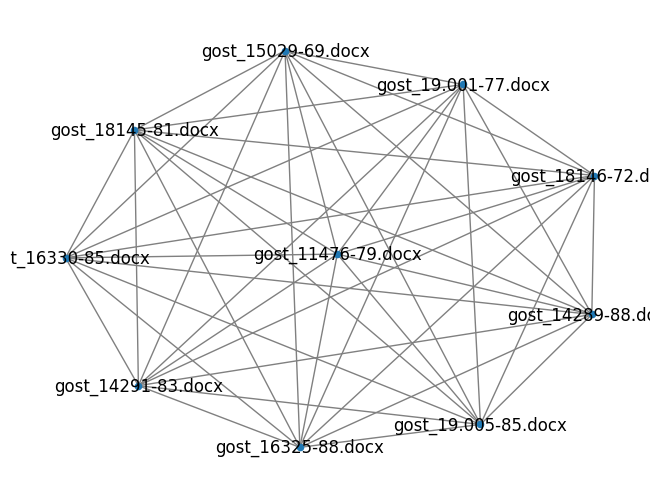

In [163]:
nx.draw(graph, node_size=20, edge_color='gray', labels={key: key.split('/')[1] for key in doc_to_topics.keys()})

In [173]:
doc_to_heavy_keywords = {}

for docname, content in doc_to_topics.items():
    first_topic = np.array(content[0][0])
    top_ten = first_topic.argsort()[::-1][:10]
    doc_to_heavy_keywords[docname] = [(id2word[i], i, first_topic[i]) for i in top_ten]

In [174]:
doc_to_heavy_keywords

{'docx35/gost_11476-79.docx': [('ввод', 64, 0.03839632),
  ('включить', 218, 0.029160948),
  ('оба', 70, 0.027282014),
  ('23675', 110, 0.02235022),
  ('весь', 222, 0.016525457),
  ('переводиться', 219, 0.014426572),
  ('дача', 67, 0.0143476855),
  ('сигнал', 114, 0.012571776),
  ('стык', 9, 0.01154608),
  ('передавать', 214, 0.0087830275)],
 'docx35/gost_14289-88.docx': [('ввод', 64, 0.033366397),
  ('включить', 218, 0.027834164),
  ('оба', 70, 0.020520173),
  ('23675', 110, 0.015601974),
  ('переводиться', 219, 0.010283912),
  ('весь', 222, 0.010041507),
  ('дача', 67, 0.0092261825),
  ('стык', 9, 0.008841067),
  ('сигнал', 114, 0.0076866155),
  ('готовность', 231, 0.0073390836)],
 'docx35/gost_14291-83.docx': [('ввод', 64, 0.057373695),
  ('включить', 218, 0.03801469),
  ('оба', 70, 0.034016266),
  ('23675', 110, 0.029451367),
  ('сигнал', 114, 0.01670856),
  ('весь', 222, 0.014731126),
  ('стык', 9, 0.014560529),
  ('переводиться', 219, 0.014181502),
  ('дача', 67, 0.013114853),
  